In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
make_notebook_pretty()

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Make initial model

In [5]:
with open("/home/sultan/recipes/exploratory_search-variant2.yml", "r") as f:
    yaml_string = f.read()

DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"
specific_topics = [f'topic_{i}' for i in range(35)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = yaml_string.format(
    modality1='@word',
    modality2='@post_tag',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described in the article
# Multi-objective Topic Modeling for Exploratory Search in Tech News
# by Anastasya Yanina, Lev Golitsyn and Konstantin Vorontsov, Jan 2018


# Use .format(modality=modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, in the actuall article 200 topics were found to be optimal
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34']
    background_topics: ['bcg_35']

regularizers:
- DecorrelatorPhiRegularizer:


### Define Topic Model

In [6]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./ExploratoryResearchDemo2') == True:
    os.system("rm -rf ./ExploratoryResearchDemo2")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id='ExploratoryResearchDemo2',
    save_path='ExploratoryResearchDemo2',
)

In [7]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)
/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Max progression length exceeded
  warnings.warn(warning_message)


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7f7fc904e4e0>}

In [8]:
experiment.show()

Experiment ExploratoryResearchDemo2

Experiment was made with BigARTM 0.9.0
Tree:
                                                                                                                                        ┌##17h38m39s_18d11m2019y###
                                ┌##17h37m38s_18d11m2019y###─────────────────────────────────────────────────────────────────────────────┤
                                │                                                                                                       ├##17h38m53s_18d11m2019y###
                                │                                                                                                       │                                                                                                                                                                                                                                                                                                                       ┌##1

In [9]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

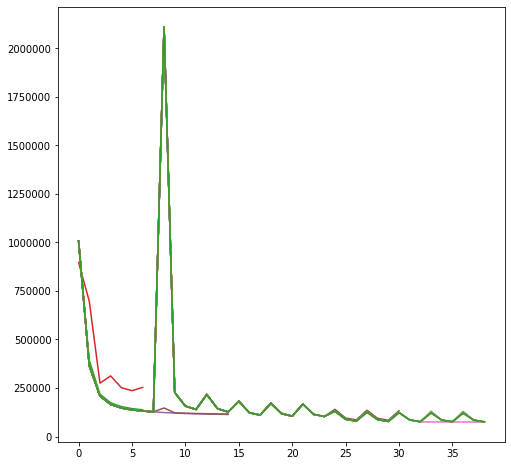

In [10]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:])
plt.show()

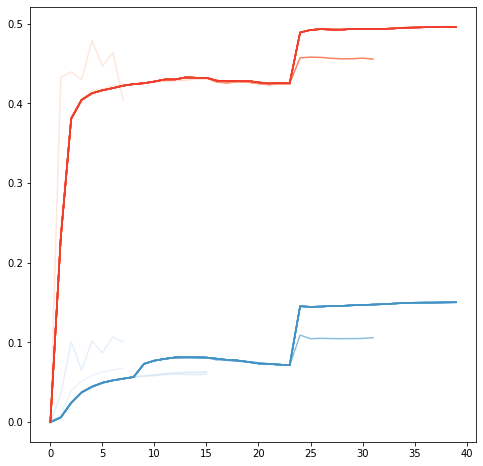

In [11]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
plt.show()

In [12]:
query = (
    "TopicKernel@word.average_contrast > 0.8 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.8 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query + " COLLECT all")
def describe_model(model):
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@word.average_contrast"][-1])
    print(model.scores["TopicKernel@word.average_purity"][-1])
    print("------")
for model in models:
    describe_model(model)

smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@post_tag 1000000.0
smooth_phi_@post_tag 0
74572.734375
0.49612024426460266
0.15030167996883392
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@post_tag 1000000.0
smooth_phi_@post_tag 0.25
74797.078125
0.49605539441108704
0.1502869576215744
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@post_tag 1000000.0
smooth_phi_@post_tag 0.5
75026.6328125
0.4959888458251953
0.15036341547966003
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 0
sparse_theta 0
smooth_phi_@word 0
decorrelation_phi_@post_tag 1000000.0
smooth_phi_@post_tag 0.75
75266.890625
0.49597296118736267
0.15037059783935547
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 0
sparse_theta 0
smooth_phi_@word 0
decorrela

### Investigate model

In [13]:
best_model = models[-1]

In [14]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw

In [15]:
thresh = 1e-5
demo_data = Dataset(DATASET_PATH)
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [16]:
n=7
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[-n:]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b>", raw=True)

,topic_29 @post_tag
днк,0.23838
клетка,0.21956
белки,0.11166
рнк,0.06896
клеточная_биология,0.05
мутация,0.03733
вирус,0.0288
белок,0.02872
абиогенез,0.01987
мембрана,0.01619


репликация днк

зонд на основе днк измеряет силу между клеткой и поверхностью

необычные формы днк

внутренний космос

центральная догма молекулярной биологии

цитоскелет клеток

структура прионов дрожжей

биогенез ядерных телец

теория phk-мира

регионы-организаторы эмбриона

,topic_30 @post_tag
политика,0.29684
политология,0.14717
либерализм,0.04541
демократия,0.04541
теория_принятия_решений,0.04266
идеология,0.04026
глобализация,0.03505
теория_игр,0.03243
политический_режим,0.0314
культурная_политика,0.02424


мнения избирателей и платформы партий

главыискаженная демократия

русский анархизм

выборы президента сша

либерализм в теории международных отношений

главы # дискурс и расизм

главы # стратегические ходы

faqреспубликанизм и свобода

изобретение культурной политики

республиканизм и свобода

,topic_31 @post_tag
философия,0.39769
мифология,0.07356
древняя_греция,0.05347
античность,0.05345
миф,0.05171
кант_иммануил,0.04669
аристотель,0.04164
платон,0.03999
сократ,0.01977
немецкая_классическая_философия,0.01967


немецкая классическая философия как понятие

ироническая эстетика зольгера

эрос в античной культуре

«теория прибавочного элемента» к. малевича

философия сознаниясвобода воли и детерминизм

faqэрос в античной культуре

5 книг о немецкой классической философии

политическая философия эроса

faqнемецкая классическая философия как понятие

экономические взгляды сократа

,topic_32 @post_tag
право,0.23575
политическая_философия,0.12064
юриспруденция,0.11516
римское_право,0.08497
рим,0.0712
социология_права,0.04345
история_права,0.04047
мораль,0.02947
судопроизводство,0.02375
политическая_теория,0.02366


римское право

обязательства

лица

купля-продажа

владение

контракты

приобретательная давность

вещные права

залог

сервитуты

,topic_33 @post_tag
квантовая_физика,0.10232
космология,0.08476
атом,0.07271
квантовая_механика,0.05531
магнитное_поле,0.05164
электрон,0.05002
фотоны,0.04636
реликтовое_излучение,0.04625
квантовые_технологии,0.04277
оптика,0.03754


диалогиуправление светом с помощью плазмонов

оптический магнитометр

квантовые интерфейсы

технология охлаждения атомов

незатухающие токи в металлических кольцах

faqквантовые интерфейсы

лазерное детектирование радиоволн

плазмонные наноструктуры

экстремальные световые поля

у атомов обнаружили суперпозицию траекторий движения

,topic_34 @post_tag
история,0.53764
история_россии,0.10727
ссср,0.08952
власть,0.03513
русь,0.03225
историография,0.02135
сталин_иосиф,0.01844
вторая_мировая_война,0.01636
петр_i,0.01455
историческая_память,0.01419


блицкриг в оценке советской элиты

эпоха ярослава мудрого

стрелецкие бунты

гетман мазепа

лжедмитрий i

«сталин, коба и сосо. молодой сталин в исторических источниках»

россия и казацкая украина

коллективизация

коллаборационизм в ссср в годы второй мировой войны

переписка ивана грозного с андреем курбским

,bcg_35 @post_tag
россия,0.44189
общество,0.3796
государство,0.17022
библиотека,0.00819
история,9e-05
,bcg_35 @word
россия,0.01659
общество,0.01263
государство,0.01073
страна,0.00624


глобальное управление

транснациональная история

культура провинциального города в россии

русская государственная идеология

обществоразнообразие альтернатив

точка зрения # экологическая политика

faqрегиональное неравенство

какой должна быть современная библиотека?

как мы понимаем историю?

главы # история понятия «государство»

In [17]:
print(doc_id)

2345.txt


In [18]:
from topicnet.viewers import TopSimilarDocumentsViewer

In [19]:
tsdv = TopSimilarDocumentsViewer(best_model, dataset)

In [25]:
search_doc = '3384.txt'
print(dataset.get_source_document(search_doc)['raw_text'].values)
sim_docs, scores = tsdv.view(
    search_doc,
    metric='euclidean',
    num_top_similar=10)
for doc_id in sim_docs:
    document = dataset.get_source_document(doc_id)
    doc_title = document.index.values[0]
    doc_snippet = '.'.join(document['raw_text'].values[0].split('.')[:3])
    display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

['@title Феномен внезапности во Второй мировой войне | @snippet Историк Алексей Киличенков о геополитической ситуации накануне Второй мировой, польской разведке и авантюризме Гитлера\n']


200.txt @title Главы: «Брачная политика» Пруссии и России | @snippet Отрывок из книги «Екатерина II, Германия и немцы» историка Клауса Шарфа о культурных и политических связях Российской империи с дворами Германии

1225.txt @title Интервенция в годы Гражданской войны | @snippet Историк Людмила Новикова о союзных интервентах, формировании чехословацкого корпуса и причинах обострения военного противостояния

3172.txt @title Русская эмиграция и Вторая мировая война | @snippet Историк Олег Будницкий о движении Сопротивления, коллаборационистах и издательской деятельности русских эмигрантов

2061.txt @title Патриотическая риторика в годы Гражданской войны | @snippet Историк Людмила Новикова об антибольшевистском лагере, красной пропаганде и мифе об интервенции

263.txt @title Автограф # «Свитки из пепла. Еврейская “зондеркоммандо” в Аушвице-Биркенау и ее летописцы» | @snippet Историк Павел Полян о главных документах Холокоста, членах зондеркоманды и осмыслении опыта концентрационных лагерей

2611.txt @title Автограф # «Правда и ложь в истории великих открытий» | @snippet Историк науки Джон Уоллер говорит о том, как среда влияет на научную деятельность и какую память оставляет о себе учёный

3370.txt @title 5 книг об истории науки | @snippet Что читать о научных открытиях и жизни академического сообщества, рекомендует кандидат исторических наук Марина Сорокина

2656.txt @title Советская Бавария | @snippet Историк Александр Ватлин о феномене Второй Советской Баварской республики, мюнхенских коммунарах и военной пропаганде в мирное время

1032.txt @title «Зондеркоммандо» | @snippet Историк Павел Полян о лагерях смерти, зондеркоманде Аушвица и документах Холокоста

1839.txt @title Культурная память о Первой мировой | @snippet Историк Борис Колоницкий об источниках информации о Первой мировой войне, политике памяти европейских стран и травме Гражданской войны